### Run onece, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Scraper part, no need to run, just in case, can be adapted to other datasource
* Fit Erik's code into Scrapy(20 minutes now). Scraping publish time of news.

* To run it, put 'MINDlarge_train' in the top level directory of the project, which is 'DM-project'
  * don't submit MINDlarge_train, add it to gitignore

* Output filepath is 'DM-project/generate/newstimes.csv'

* Don't forget to go back to the top level directory

In [2]:
#%cd scraper

In [3]:
#!scrapy crawl news

In [4]:
#%cd ..

In [ ]:
#newsTimes = 'generate/newstimes.csv'

### Load Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
entityEmbedding = 'MINDlarge_train/entity_embedding.vec'

### Preprocssing, run once

In [8]:
#import preprocessing.preprocessing as pre

In [9]:
#generate news_embedding.csv, news_cleaned.csv
#pre.createNews(news,newsTimes,entityEmbedding)

#generate user_history.csv, user_impression.csv
#pre.createUsers(behaviors)

#split big files
#pre.splitFiles('generate/user_history.csv')
#pre.splitFiles('generate/user_impressions.csv')

### Categorical Embedding capture trending

In [ ]:
df_news = pd.read_csv('generate/news_cleaned.csv')
df_embeddings = pd.read_csv('generate/news_embedding.csv')

### Category embedding - solution 2

Use nlp embedding, tokenize subcategories
* i.e 
  * lifestylecelebrity-->lifestyle celebrity
  * finance-investing-->finance investing
  * football_fifa_wwc-->football fifa wwc
* I made it by hand,because only 284 of them. In real world messy data, we can applying hidden markov model to maximize likelihood of possibility chain.(idea from Chinese NLP segmentation)

* Pros:
  * Capture relations in context that is the relation across categories while one-hot encoding doesn't.
  * PinSage did so. They joint two embeddings ,vision embedding(picture) from CNN, context embedding(description, labels) from word2vec.

* Cons: 
  * Still 300 dimensions in a embedding vector. (spacy, here), if we do one-hot, 284 only.
       * PCA！ 

### No need to run, already generated, but in case you want to play around.
* generate/news_subcat_embedding_nlp.csv

In [22]:
#!pip3 install spacy

In [28]:
#!python3 -m spacy download en_core_web_lg

In [207]:
#subcategories = "generate/news_subcategories.csv"
#pre.createCategoriyEmbeddingNLP(subcategories)

fcluster### Clustering!

In [367]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist,cosine,cdist

def clustering(X,vectorColumns,threshold,lam):
    m,n = X.shape
    #print(X)
    if m>1:
        pairwise_distance = pdist(X[vectorColumns], metric='cosine')
        
        labels = fcluster(ward(pairwise_distance), t=threshold, criterion='distance')
        #print(labels)
        num_clusters = labels.max()
        
        scores = {}
        for i in range(num_clusters):
            c = i+1 #choose cluster
            #if we use sum, both consider number of item and time importance
            importance_score = X.loc[labels==c].importance.sum()
            scores[c] = importance_score
        
        if num_clusters>3:
            p = np.array(list(scores.values()))
            sum_score = p.sum()
            p /= sum_score
            chosed = np.random.choice(list(scores.keys()),p=p,size=3,replace=False)
        else:
            chosed = np.array(list(scores.keys()))
            
        medoids = []
        distance_upper_bound = []
        for c in chosed:
            idx = np.argwhere(labels==c).flatten()
            
            if len(idx)<3:
                distance_upper_bound.append(0.5)   
                medoids.append(X.index[idx[0]])
                continue
                
            min_distance = 9999999
            min_distance_i = -1
            min_distances = []
            
            
            for i in idx:
                distance_i = 0
                distances = []
                for j in idx:
                    if i==j:
                        continue
                        
                    d_ij = m * i + j - ((i + 2) * (i + 1)) // 2.
                    distance_i_j =  pairwise_distance[int(d_ij)]
                    distance_i += distance_i_j
                    distances.append(distance_i_j)
                    
                    if distance_i>min_distance:
                        break
                        
                if distance_i<min_distance:
                    min_distance = distance_i
                    min_distance_i = i
                    min_distances = distances
            

                  
            std = np.array(min_distances).std()
            mu = np.array(min_distances).mean()
            #68%-95%-99.8% for 1,2,3 std
            #!!!!!however
            #according to the result, larger cluster has lower std.
            distance_upper_bound.append(mu+2*std)   
            medoids.append(X.index[min_distance_i])
            
        return medoids,distance_upper_bound
    else:
        return X.index.values,0.5*np.ones(X.shape[0])
    
def clusteringBatch(history,t0,threshold=0.7,lam=0.01):
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_news_meta = pd.read_csv('generate/news_cleaned.csv')
    
    df_history = pd.read_csv(history)
    
    
   # df_history = df_history[df_history.UID=='U169741']
 
    df_history = df_history.merge(df_news_embedding,on='NID')
    df_history = df_history.merge(df_news_meta,on='NID')


    df_history['importance'] = np.exp(-lam*(t0-df_history.publishDate)/100000)

    vectorColumns = [c for c in df_history.columns if c.startswith('V')]

    medoid_collection = []
    radius_collection = []
    for UID,g in df_history.groupby('UID'):
        medoids,radius = clustering(g,vectorColumns,threshold,lam)
        
        medoid_collection.append(medoids)
        radius_collection.append(radius)
        
    df_result = df_history.loc[np.hstack(medoid_collection)][['UID','NID']].copy()
    df_result['radius'] = np.hstack(radius_collection)
    return df_result

In [368]:
def measurement(impression,df_user_representation):
    df_impression = pd.read_csv(impression)
    df_impression = df_impression[df_impression.attitude==1]
    
   # df_impression = df_impression[df_impression.UID=='U169741']
    
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_impression = df_impression.merge(df_news_embedding,on='NID')
    df_user_representation = df_user_representation.merge(df_news_embedding,on='NID')
    
    vectorColumns = [c for c in df_impression.columns if c.startswith('V')]
    
    measure = []
    for UID,g in df_impression.groupby('UID'):
        #print(df_user_representation[df_user_representation.UID==UID])
        positive = g[vectorColumns]
        user = df_user_representation[df_user_representation.UID==UID][vectorColumns]
        user_radius = df_user_representation[df_user_representation.UID==UID].radius.values
        
        if len(user)==0:
            continue
        
        d = cdist(positive,user, metric='cosine')
       
        where_clusters = d.argmin(axis=1)
        user_radius = user_radius[where_clusters]
       
        
        mask = d==(d.min(keepdims=1,axis=1))
        
        #print(UID,mask,user)
        
        hits = d[mask] < user_radius
       
        recall = hits.mean()
       
        hit = 1 - len(np.unique(where_clusters[hits]))/len(user)
       
        measure.append((UID,recall,hit))
        
    return pd.DataFrame.from_records(measure,columns=['UID','recall','percent_empty'])

### do ward clustering

In [369]:
t0 = 1575586800+1000
lam = 0.01
threshold = 0.85

history = 'generate/user_history_1.csv'
df_user_representation = clusteringBatch(history,t0,threshold=threshold,lam=lam)

In [370]:
df_user_representation

,UID,NID,radius
281845,U1,N129422,0.906985
181346,U1,N116144,0.680698
102419,U1,N27258,0.309544
220210,U100009,N72493,0.802330
203617,U100045,N76810,0.500000
...,...,...,...
34830,U99937,N102417,0.500000
97318,U99937,N104760,0.500000
60006,U99973,N42703,0.500000
33458,U99973,N9375,0.874542


<AxesSubplot:>

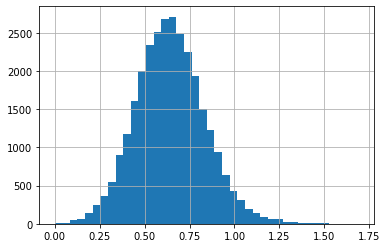

In [371]:
df_user_representation[~(df_user_representation.radius==0.5)].radius.hist(bins=40)

### measure user representation

In [372]:
impression = 'generate/user_impressions_1.csv'

df_measure = measurement(impression,df_user_representation)

<AxesSubplot:>

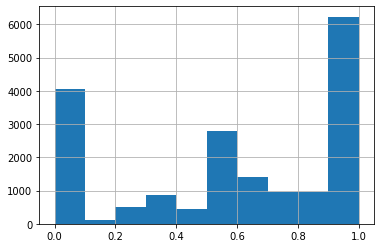

In [377]:
df_measure.recall.hist(bins=10)

<AxesSubplot:>

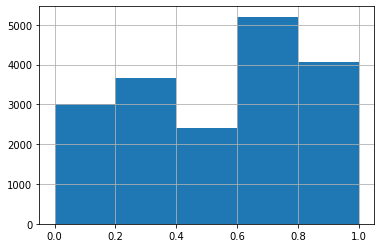

In [376]:
df_measure.percent_empty.hist(bins=5)